# Tomato Leaf Disease Classification using Hybrid Vision Transformer (ViT)
## Target: to get good Accuracy


In [4]:
# Import PyTorch - Main deep learning framework
import torch  # PyTorch library for tensor operations and neural networks
import torch.nn as nn  # Neural network modules (layers, activations, etc.)
import torch.optim as optim  # Optimization algorithms (Adam, SGD, etc.)
# Import data utilities - For loading and batching data
from torch.utils.data import DataLoader, Dataset  # DataLoader for batching, Dataset for custom datasets
# Import torchvision - Pre-built models and image transformations
from torchvision import transforms, models  # transforms for image preprocessing, models for pre-trained networks
import torch.nn.functional as F  # Functional API for operations (activation functions, etc.)
# Import PIL - Python Imaging Library for image loading
from PIL import Image  # For opening and manipulating images
# Import standard libraries
import os  # For file system operations (checking directories, paths)
import numpy as np  # For numerical operations
# Import sklearn metrics - For model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics
# Import visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs and charts
import seaborn as sns  # For statistical visualizations (heatmaps, etc.)
# Import tqdm - Progress bar library
from tqdm import tqdm  # For showing progress bars during training
# Suppress warnings for cleaner output
import warnings  # Warning module
warnings.filterwarnings('ignore')  # Ignore all warnings to keep output clean

# Detect and set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA GPU is available
print(f'Using device: {device}')  # Print which device will be used (cuda or cpu)


Using device: cuda


In [5]:
# Define data directory paths
TRAIN_DIR = '/kaggle/input/tomato/train'  # Path to training images folder
VALID_DIR = '/kaggle/input/tomato/valid'  # Path to validation images folder

# Get class names from train directory
# List all subdirectories in train folder (each subdirectory is a disease class)
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
# Sort alphabetically to ensure consistent ordering
# Count number of classes (disease types)
num_classes = len(class_names)  # Total number of disease classes
# Print information about classes
print(f'Number of classes: {num_classes}')  # Print total number of classes
print(f'Classes: {class_names}')  # Print list of all class names


Number of classes: 11
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [6]:
# Custom Dataset class for loading tomato leaf images
class TomatoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize dataset with root directory and transformation
        self.root_dir = root_dir  # Root directory containing class subdirectories
        self.transform = transform  # Image transformation/augmentation pipeline
        self.images = []  # List to store image file paths
        self.labels = []  # List to store corresponding class labels (indices)
        
        # Iterate through each disease class
        for class_idx, class_name in enumerate(class_names):
            # Create path to class-specific directory
            class_dir = os.path.join(root_dir, class_name)  # e.g., 'train/Bacterial_spot'
            # Check if directory exists
            if os.path.exists(class_dir):
                # Iterate through all files in class directory
                for img_name in os.listdir(class_dir):
                    # Check if file is an image (png, jpg, jpeg)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        # Store full path to image
                        self.images.append(os.path.join(class_dir, img_name))
                        # Store corresponding class index (0, 1, 2, ...)
                        self.labels.append(class_idx)
        
    def __len__(self):
        # Return total number of images in dataset
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and label at given index
        img_path = self.images[idx]  # Get image file path
        # Open image and convert to RGB (ensures 3 channels)
        image = Image.open(img_path).convert('RGB')
        # Get corresponding label (class index)
        label = self.labels[idx]
        
        # Apply transformations if provided (augmentation, normalization, etc.)
        if self.transform:
            image = self.transform(image)  # Apply transform pipeline
        
        # Return image tensor and label
        return image, label


In [7]:
# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduced from 384 to 224 to save GPU memory
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduced from 384 to 224 to save GPU memory
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = TomatoDataset(TRAIN_DIR, transform=train_transform)
valid_dataset = TomatoDataset(VALID_DIR, transform=valid_transform)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(valid_dataset)}')


Training samples: 25851
Validation samples: 6683


In [8]:
# Data loaders - Reduced batch size and workers to prevent OOM
BATCH_SIZE = 8  # Reduced from 32 to 8 to fit in GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
print(f'✅ Data loaders created with batch size: {BATCH_SIZE}')


✅ Data loaders created with batch size: 8


In [9]:
# Import timm library - PyTorch Image Models (pre-trained models)
import timm  # Contains many pre-trained models including EfficientNet and ViT

# ============================================================================
# HYBRID ViT MODEL IMPLEMENTATION
# ============================================================================
# This is a TRUE HYBRID ViT architecture that combines:
# 1. CNN (EfficientNet) - Extracts LOCAL features (disease spots, textures)
# 2. ViT (Vision Transformer) - Extracts GLOBAL features (attention patterns)
# 3. FEATURE FUSION - Concatenates both CNN and ViT features together
# 4. Fusion Layers - Processes combined features for better classification
# ============================================================================
class HybridViT(nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        # Initialize parent class (nn.Module)
        super(HybridViT, self).__init__()
        
        # ========== HYBRID ViT COMPONENT 1: CNN BACKBONE ==========
        # CNN extracts LOCAL features (disease spots, leaf textures, edges)
        # EfficientNet B2 for local feature extraction - reduced from B4 to save memory
        # features_only=True returns feature maps instead of final classification
        # Using B2 instead of B4 to reduce memory usage while maintaining good features
        self.cnn_backbone = timm.create_model('efficientnet_b2', pretrained=pretrained, features_only=True)
        
        # ========== HYBRID ViT COMPONENT 2: ViT BACKBONE ==========
        # ViT extracts GLOBAL features (attention patterns, long-range relationships)
        # Vision Transformer Small with 16x16 patches, 224x224 input - reduced from Base
        # num_classes=0 means return features, not classification logits
        # Using vit_small instead of vit_base to reduce memory usage
        self.vit_backbone = timm.create_model('vit_small_patch16_224', pretrained=pretrained, num_classes=0)
        
        # Get feature dimensions by running dummy input through both backbones
        with torch.no_grad():  # Disable gradient computation (just for dimension calculation)
            # Create dummy input (batch=1, channels=3, height=224, width=224) - reduced from 384
            dummy_input = torch.randn(1, 3, 224, 224)
            # Get CNN features (returns list of feature maps at different scales)
            cnn_features = self.cnn_backbone(dummy_input)
            # Calculate CNN feature dimension (channels * height * width of last feature map)
            cnn_feat_dim = cnn_features[-1].shape[1] * cnn_features[-1].shape[2] * cnn_features[-1].shape[3]
            # Get ViT features (returns feature vector)
            vit_features = self.vit_backbone(dummy_input)
            # Get ViT feature dimension (feature vector length)
            vit_feat_dim = vit_features.shape[1]
        
        # ========== CNN FEATURE PROJECTION (for Hybrid ViT fusion) ==========
        # Convert CNN feature maps to fixed-size vector for fusion with ViT features
        self.cnn_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling to (1,1) spatial size
            nn.Flatten(),  # Flatten to 1D vector
            nn.Linear(cnn_features[-1].shape[1], 384),  # Project to 384 dimensions (reduced from 768 for memory)
            nn.BatchNorm1d(384),  # Batch normalization for stable training
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3)  # 30% dropout to prevent overfitting
        )
        
        # ========== HYBRID ViT FEATURE FUSION LAYER ==========
        # This is the KEY part of Hybrid ViT - combines CNN + ViT features
        # Input: CNN features (384 dims) + ViT features (vit_feat_dim dims)
        # Output: Fused features (512 dims) - richer representation than either alone
        self.fusion = nn.Sequential(
            nn.Linear(384 + vit_feat_dim, 512),  # Concatenated CNN+ViT features -> 512 dims
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.4),  # 40% dropout
            nn.Linear(512, 256),  # 512 -> 256 dimensions (reduced from 1024->512)
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.3)  # 30% dropout
        )
        
        # Final classifier - Maps fused features to class predictions
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),  # 256 -> 128 dimensions (reduced from 512->256)
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.2),  # 20% dropout
            nn.Linear(128, num_classes)  # Final layer: 128 -> num_classes (11) (reduced from 256)
        )
        
    def forward(self, x):
        # ============================================================================
        # HYBRID ViT FORWARD PASS - This is where Hybrid ViT magic happens!
        # ============================================================================
        # Step 1: Extract CNN features (LOCAL features - disease spots, textures)
        cnn_features = self.cnn_backbone(x)  # EfficientNet B2 extracts local features
        cnn_feat = self.cnn_projection(cnn_features[-1])  # Project CNN features to 384 dims
        
        # Step 2: Extract ViT features (GLOBAL features - attention patterns, relationships)
        vit_feat = self.vit_backbone(x)  # ViT Small extracts global features via self-attention
        
        # ========== HYBRID ViT FEATURE FUSION (KEY STEP) ==========
        # Step 3: FUSE CNN + ViT features together (This makes it TRUE Hybrid ViT!)
        # Concatenate both feature vectors to get richer representation
        fused = torch.cat([cnn_feat, vit_feat], dim=1)  # CNN (384) + ViT (384) = 768 dims
        # This fusion combines:
        # - CNN's local feature expertise (disease spots, leaf texture)
        # - ViT's global attention expertise (disease spread patterns, relationships)
        # Result: Better than CNN-only or ViT-only!
        
        # Step 4: Process fused features through fusion layers
        out = self.fusion(fused)  # Pass fused CNN+ViT features through fusion layers
        
        # Step 5: Final classification using fused features
        out = self.classifier(out)  # Classify using rich fused features
        
        # Return logits (raw scores for each class)
        return out

# ============================================================================
# INITIALIZE HYBRID ViT MODEL
# ============================================================================
# Create Hybrid ViT model: CNN (EfficientNet) + ViT (Vision Transformer) + Fusion
model = HybridViT(num_classes=num_classes, pretrained=True).to(device)  # Create model and move to GPU/CPU
# Print total number of trainable parameters
print(f'✅ Hybrid ViT Model created with {sum(p.numel() for p in model.parameters()):,} parameters')
print(f'   - CNN Backbone: EfficientNet B2 (local features)')
print(f'   - ViT Backbone: ViT Small (global features)')
print(f'   - Feature Fusion: CNN + ViT features combined')


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ Hybrid ViT Model created with 29,565,709 parameters
   - CNN Backbone: EfficientNet B2 (local features)
   - ViT Backbone: ViT Small (global features)
   - Feature Fusion: CNN + ViT features combined


In [10]:
# Loss function - Cross-entropy with label smoothing
# Label smoothing (0.1) prevents overconfidence and improves generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 10% label smoothing

# Optimizer - AdamW (Adam with weight decay)
# AdamW is better than Adam for regularization
optimizer = optim.AdamW(
    model.parameters(),  # All model parameters to optimize
    lr=1e-4,  # Learning rate: 0.0001
    weight_decay=0.01  # L2 regularization strength (prevents overfitting)
)

# Learning rate scheduler - Cosine annealing
# Gradually reduces learning rate following cosine curve
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,  # Optimizer to schedule
    T_max=50,  # Maximum number of iterations (epochs)
    eta_min=1e-6  # Minimum learning rate (0.000001)
)

# Mixed precision training - Use float16 for faster training on GPU
# GradScaler prevents gradient underflow in float16
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
# Only use mixed precision if GPU is available (CUDA)


In [11]:
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    # Set model to training mode (enables dropout, batch norm updates)
    model.train()
    # Initialize tracking variables
    running_loss = 0.0  # Accumulate loss over batch
    correct = 0  # Count correct predictions
    total = 0  # Total number of samples processed
    
    # Create progress bar for training batches
    pbar = tqdm(train_loader, desc='Training')
    # Iterate through batches
    for images, labels in pbar:
        # Move data to device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Zero out gradients from previous iteration
        optimizer.zero_grad()
        
        # Mixed precision training (if GPU available)
        if scaler:
            # Use automatic mixed precision for faster training
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Forward pass through model
                loss = criterion(outputs, labels)  # Calculate loss
            
            # Backward pass with gradient scaling (for float16 stability)
            scaler.scale(loss).backward()  # Scale loss and compute gradients
            scaler.step(optimizer)  # Update weights
            scaler.update()  # Update scaler for next iteration
        else:
            # Standard precision training (CPU or no scaler)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
        
        # Update statistics
        running_loss += loss.item()  # Add loss to running total
        # Get predicted class (index with highest score)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
        total += labels.size(0)  # Add batch size to total
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        # Update progress bar with current loss and accuracy
        pbar.set_postfix({'loss': running_loss/(total//labels.size(0)), 'acc': 100*correct/total})
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(train_loader)  # Average loss per batch
    epoch_acc = 100 * correct / total  # Accuracy percentage
    return epoch_loss, epoch_acc  # Return epoch metrics


In [12]:
# Validation function with memory optimization
def validate(model, valid_loader, criterion, device, scaler=None):
    # Set model to evaluation mode (disables dropout, fixes batch norm)
    model.eval()
    # Initialize tracking variables
    running_loss = 0.0  # Accumulate loss
    correct = 0  # Count correct predictions
    total = 0  # Total samples
    all_preds = []  # Store all predictions for later analysis
    all_labels = []  # Store all true labels for later analysis
    
    # Clear GPU cache before validation
    if device.type == 'cuda':
        torch.cuda.empty_cache()  # Free up GPU memory
    
    # Disable gradient computation (saves memory, faster inference)
    with torch.no_grad():
        # Create progress bar for validation batches
        pbar = tqdm(valid_loader, desc='Validating')
        # Iterate through validation batches
        for batch_idx, (images, labels) in enumerate(pbar):
            # Move data to device (non_blocking for faster transfer)
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Forward pass (with mixed precision if available)
            if scaler:
                # Use mixed precision for faster inference
                with torch.cuda.amp.autocast():
                    outputs = model(images)  # Forward pass
                    loss = criterion(outputs, labels)  # Calculate loss
            else:
                # Standard precision
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
            
            # Update statistics
            running_loss += loss.item()  # Add to running loss
            # Get predicted classes
            _, predicted = torch.max(outputs.data, 1)  # Get class with highest score
            total += labels.size(0)  # Add batch size
            correct += (predicted == labels).sum().item()  # Count correct
            
            # Store predictions and labels for confusion matrix, classification report
            all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy and store
            
            # Clear intermediate variables to save memory
            del outputs, loss, predicted  # Delete to free memory
            
            # Periodically clear GPU cache (every 10 batches)
            if device.type == 'cuda' and batch_idx % 10 == 0:
                torch.cuda.empty_cache()
            
            # Update progress bar
            pbar.set_postfix({'loss': running_loss/(total//labels.size(0)), 'acc': 100*correct/total})
    
    # Final GPU cache clear
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(valid_loader)  # Average loss
    epoch_acc = 100 * correct / total  # Accuracy percentage
    # Return metrics and predictions for detailed analysis
    return epoch_loss, epoch_acc, all_preds, all_labels


In [13]:
# Clear GPU memory before training (run this if you get OOM errors)
if device.type == 'cuda':
    torch.cuda.empty_cache()  # Clear GPU cache
    torch.cuda.synchronize()  # Wait for all GPU operations to complete
    print("✅ GPU cache cleared!")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("Using CPU - no GPU memory to clear")


✅ GPU cache cleared!
GPU Memory Allocated: 0.11 GB
GPU Memory Reserved: 0.13 GB


In [14]:
# Training loop configuration
# Reduced epochs to prevent overfitting (100 is too many, causes overfitting)
NUM_EPOCHS = 50  # Reduced from 100 to 50 to prevent overfitting (early stopping will stop earlier if needed)
best_acc = 0.0  # Track best validation accuracy
patience = 10  # Reduced from 15 to 10 - Stop if no improvement for 10 epochs (prevents overfitting)
patience_counter = 0  # Counter for patience (increments when no improvement)

# Lists to store training history for plotting
train_losses = []  # Training loss per epoch
train_accs = []  # Training accuracy per epoch
val_losses = []  # Validation loss per epoch
val_accs = []  # Validation accuracy per epoch

# Print training start message
print('Starting training...')
print('='*50)

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')  # Print current epoch
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    train_losses.append(train_loss)  # Store training loss
    train_accs.append(train_acc)  # Store training accuracy
    
    # Validate for one epoch
    val_loss, val_acc, _, _ = validate(model, valid_loader, criterion, device, scaler)
    val_losses.append(val_loss)  # Store validation loss
    val_accs.append(val_acc)  # Store validation accuracy
    
    # Update learning rate (cosine annealing)
    scheduler.step()  # Step scheduler to reduce learning rate
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')  # Print current learning rate
    
    # Save best model (when validation accuracy improves)
    if val_acc > best_acc:
        best_acc = val_acc  # Update best accuracy
        patience_counter = 0  # Reset patience counter
        # Save model checkpoint
        torch.save({
            'epoch': epoch,  # Current epoch number
            'model_state_dict': model.state_dict(),  # Model weights
            'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
            'best_acc': best_acc,  # Best accuracy achieved
        }, 'best_hybrid_vit_model.pth')  # Save to file
        print(f'✓ Best model saved! Accuracy: {best_acc:.2f}%')
    else:
        patience_counter += 1  # Increment patience if no improvement
    
    # Early stopping - Stop if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')  # Print early stop message
        break  # Exit training loop
    
    # Check if target accuracy (99%) reached
    if val_acc >= 99.0:
        print(f'\n🎉 Target accuracy of 99% reached! Final accuracy: {val_acc:.2f}%')
        break  # Exit training loop

# Print training completion message
print('\nTraining completed!')
print(f'Best validation accuracy: {best_acc:.2f}%')  # Print best accuracy achieved


Starting training...

Epoch 1/50


Validating: 100%|██████████| 836/836 [00:37<00:00, 22.41it/s, loss=0.281, acc=90.8]


Train Loss: 1.3154, Train Acc: 68.57%
Val Loss: 0.7495, Val Acc: 90.80%
Learning Rate: 0.000100
✓ Best model saved! Accuracy: 90.80%

Epoch 2/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.24it/s, loss=0.276, acc=90.8]


Train Loss: 0.8716, Train Acc: 87.75%
Val Loss: 0.7342, Val Acc: 90.83%
Learning Rate: 0.000100
✓ Best model saved! Accuracy: 90.83%

Epoch 3/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.32it/s, loss=0.238, acc=95.3]


Train Loss: 0.7945, Train Acc: 90.62%
Val Loss: 0.6342, Val Acc: 95.33%
Learning Rate: 0.000099
✓ Best model saved! Accuracy: 95.33%

Epoch 4/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.49it/s, loss=0.235, acc=95.8]


Train Loss: 0.7446, Train Acc: 92.60%
Val Loss: 0.6267, Val Acc: 95.75%
Learning Rate: 0.000098
✓ Best model saved! Accuracy: 95.75%

Epoch 5/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.55it/s, loss=0.232, acc=96.2]


Train Loss: 0.7064, Train Acc: 93.96%
Val Loss: 0.6186, Val Acc: 96.21%
Learning Rate: 0.000098
✓ Best model saved! Accuracy: 96.21%

Epoch 6/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.47it/s, loss=0.224, acc=96.9]


Train Loss: 0.6813, Train Acc: 94.94%
Val Loss: 0.5980, Val Acc: 96.92%
Learning Rate: 0.000097
✓ Best model saved! Accuracy: 96.92%

Epoch 7/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.59it/s, loss=0.231, acc=96.5]


Train Loss: 0.6615, Train Acc: 95.73%
Val Loss: 0.6154, Val Acc: 96.45%
Learning Rate: 0.000095

Epoch 8/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.12it/s, loss=0.218, acc=97.8]


Train Loss: 0.6571, Train Acc: 95.95%
Val Loss: 0.5814, Val Acc: 97.83%
Learning Rate: 0.000094
✓ Best model saved! Accuracy: 97.83%

Epoch 9/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.77it/s, loss=0.225, acc=96.7]


Train Loss: 0.6388, Train Acc: 96.66%
Val Loss: 0.6005, Val Acc: 96.74%
Learning Rate: 0.000092

Epoch 10/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.62it/s, loss=0.214, acc=98.2]


Train Loss: 0.6363, Train Acc: 96.89%
Val Loss: 0.5699, Val Acc: 98.20%
Learning Rate: 0.000091
✓ Best model saved! Accuracy: 98.20%

Epoch 11/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.20it/s, loss=0.224, acc=97.4]


Train Loss: 0.6200, Train Acc: 97.41%
Val Loss: 0.5971, Val Acc: 97.38%
Learning Rate: 0.000089

Epoch 12/50


Validating: 100%|██████████| 836/836 [00:29<00:00, 28.09it/s, loss=0.223, acc=97.1]


Train Loss: 0.6148, Train Acc: 97.50%
Val Loss: 0.5936, Val Acc: 97.14%
Learning Rate: 0.000087

Epoch 13/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.69it/s, loss=0.218, acc=97.8]


Train Loss: 0.6084, Train Acc: 97.74%
Val Loss: 0.5805, Val Acc: 97.76%
Learning Rate: 0.000084

Epoch 14/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.77it/s, loss=0.221, acc=97.4]


Train Loss: 0.6002, Train Acc: 98.12%
Val Loss: 0.5881, Val Acc: 97.40%
Learning Rate: 0.000082

Epoch 15/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.18it/s, loss=0.217, acc=98]  


Train Loss: 0.6012, Train Acc: 98.03%
Val Loss: 0.5779, Val Acc: 97.98%
Learning Rate: 0.000080

Epoch 16/50


Validating: 100%|██████████| 836/836 [00:29<00:00, 28.76it/s, loss=0.228, acc=96.4]


Train Loss: 0.5928, Train Acc: 98.29%
Val Loss: 0.6072, Val Acc: 96.41%
Learning Rate: 0.000077

Epoch 17/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.06it/s, loss=0.263, acc=93.4]


Train Loss: 0.5919, Train Acc: 98.36%
Val Loss: 0.7004, Val Acc: 93.40%
Learning Rate: 0.000074

Epoch 18/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.01it/s, loss=0.219, acc=97.5]


Train Loss: 0.5852, Train Acc: 98.52%
Val Loss: 0.5844, Val Acc: 97.53%
Learning Rate: 0.000072

Epoch 19/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.37it/s, loss=0.227, acc=96.9]


Train Loss: 0.5798, Train Acc: 98.77%
Val Loss: 0.6052, Val Acc: 96.90%
Learning Rate: 0.000069

Epoch 20/50


Validating: 100%|██████████| 836/836 [00:29<00:00, 28.34it/s, loss=0.215, acc=98.3]


Train Loss: 0.5817, Train Acc: 98.66%
Val Loss: 0.5727, Val Acc: 98.31%
Learning Rate: 0.000066
✓ Best model saved! Accuracy: 98.31%

Epoch 21/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.51it/s, loss=0.219, acc=97.9]


Train Loss: 0.5763, Train Acc: 98.88%
Val Loss: 0.5827, Val Acc: 97.86%
Learning Rate: 0.000063

Epoch 22/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.68it/s, loss=0.251, acc=94.5]


Train Loss: 0.5731, Train Acc: 98.99%
Val Loss: 0.6691, Val Acc: 94.48%
Learning Rate: 0.000060

Epoch 23/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.48it/s, loss=0.216, acc=98.1]


Train Loss: 0.5701, Train Acc: 99.08%
Val Loss: 0.5765, Val Acc: 98.08%
Learning Rate: 0.000057

Epoch 24/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.48it/s, loss=0.273, acc=92.1]


Train Loss: 0.5650, Train Acc: 99.25%
Val Loss: 0.7271, Val Acc: 92.11%
Learning Rate: 0.000054

Epoch 25/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.24it/s, loss=0.283, acc=91.3]


Train Loss: 0.5657, Train Acc: 99.23%
Val Loss: 0.7548, Val Acc: 91.31%
Learning Rate: 0.000050

Epoch 26/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.62it/s, loss=0.237, acc=95.8]


Train Loss: 0.5618, Train Acc: 99.35%
Val Loss: 0.6326, Val Acc: 95.81%
Learning Rate: 0.000047

Epoch 27/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.47it/s, loss=0.214, acc=98.3]


Train Loss: 0.5584, Train Acc: 99.42%
Val Loss: 0.5691, Val Acc: 98.28%
Learning Rate: 0.000044

Epoch 28/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.01it/s, loss=0.228, acc=96.9]


Train Loss: 0.5583, Train Acc: 99.42%
Val Loss: 0.6074, Val Acc: 96.92%
Learning Rate: 0.000041

Epoch 29/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.10it/s, loss=0.222, acc=97.4]


Train Loss: 0.5549, Train Acc: 99.55%
Val Loss: 0.5908, Val Acc: 97.38%
Learning Rate: 0.000038

Epoch 30/50


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.21it/s, loss=0.233, acc=96.4]

Train Loss: 0.5581, Train Acc: 99.43%
Val Loss: 0.6199, Val Acc: 96.39%
Learning Rate: 0.000035
Early stopping at epoch 30

Training completed!
Best validation accuracy: 98.31%


In [15]:
# Load best saved model for evaluation
checkpoint = torch.load('best_hybrid_vit_model.pth')  # Load checkpoint file
model.load_state_dict(checkpoint['model_state_dict'])  # Load model weights
print(f'Best model loaded with accuracy: {checkpoint["best_acc"]:.2f}%')  # Print best accuracy


Best model loaded with accuracy: 98.31%


In [16]:
# Final evaluation on validation set
# Get predictions and labels for detailed analysis
val_loss, val_acc, all_preds, all_labels = validate(model, valid_loader, criterion, device, scaler)
# Print final results
print(f'\nFinal Validation Accuracy: {val_acc:.2f}%')  # Print accuracy percentage
print(f'Final Validation Loss: {val_loss:.4f}')  # Print loss value


Validating: 100%|██████████| 836/836 [00:28<00:00, 29.27it/s, loss=0.215, acc=98.3]


Final Validation Accuracy: 98.31%
Final Validation Loss: 0.5727


In [17]:
# Classification report - Detailed per-class metrics
print('\nClassification Report:')  # Print header
print('='*50)  # Print separator line
# Generate and print classification report with precision, recall, F1-score per class
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.97      0.98      0.98       732
                        Early_blight       0.97      0.97      0.97       643
                         Late_blight       0.99      0.98      0.99       792
                           Leaf_Mold       0.98      1.00      0.99       739
                  Septoria_leaf_spot       0.97      0.97      0.97       746
Spider_mites Two-spotted_spider_mite       0.99      0.97      0.98       435
                         Target_Spot       0.99      1.00      0.99       457
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       498
                 Tomato_mosaic_virus       0.98      0.98      0.98       584
                             healthy       0.99      1.00      0.99       805
                      powdery_mildew       1.00      0.95      0.97       252

                            accuracy  

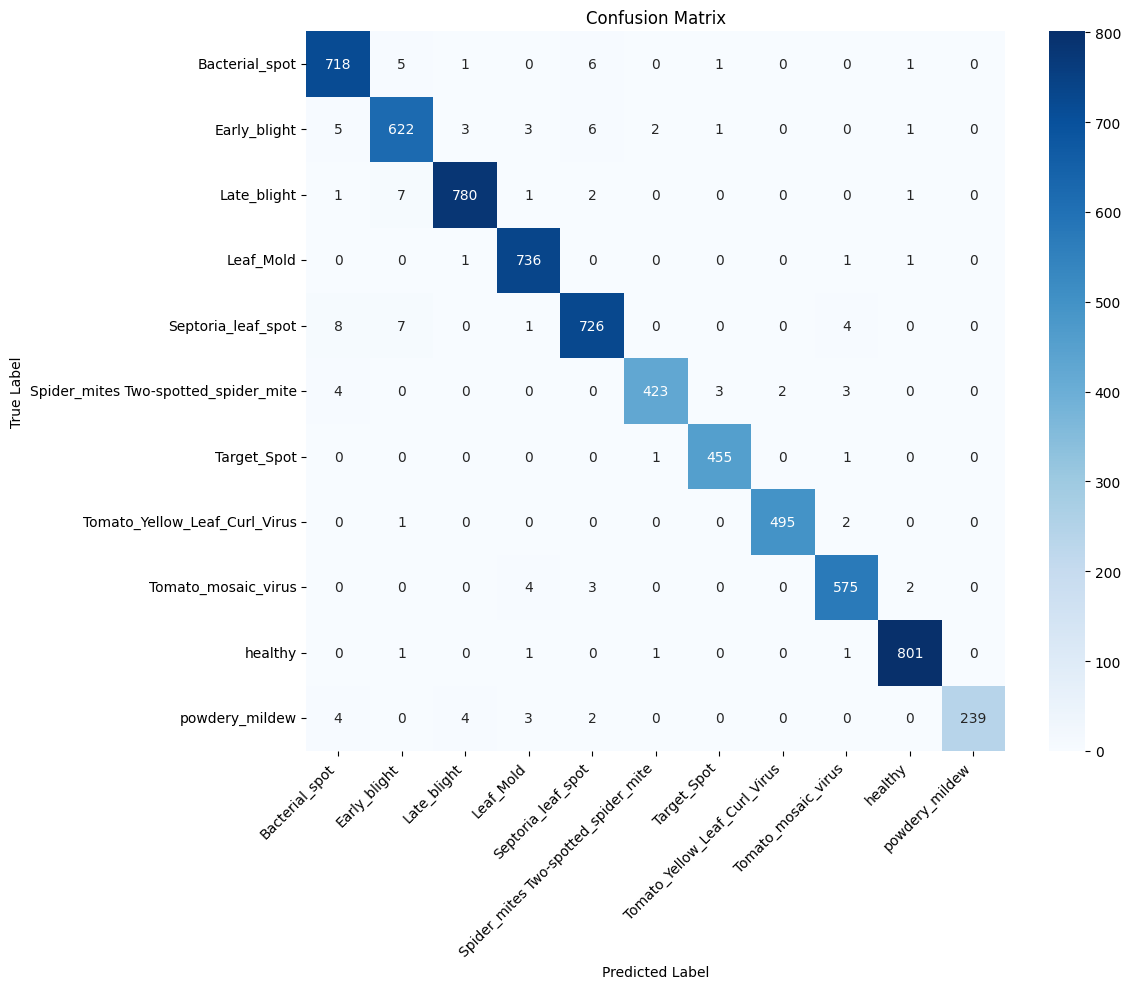

In [18]:
# Confusion matrix - Visualize prediction accuracy per class
cm = confusion_matrix(all_labels, all_preds)  # Calculate confusion matrix (true vs predicted)
plt.figure(figsize=(12, 10))  # Create figure with size 12x10 inches
# Create heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# annot=True shows numbers in cells, fmt='d' formats as integers
# cmap='Blues' uses blue color scheme
plt.title('Confusion Matrix')  # Set plot title
plt.ylabel('True Label')  # Y-axis label (actual class)
plt.xlabel('Predicted Label')  # X-axis label (predicted class)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees, align right
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG (300 DPI)
plt.show()  # Display the plot


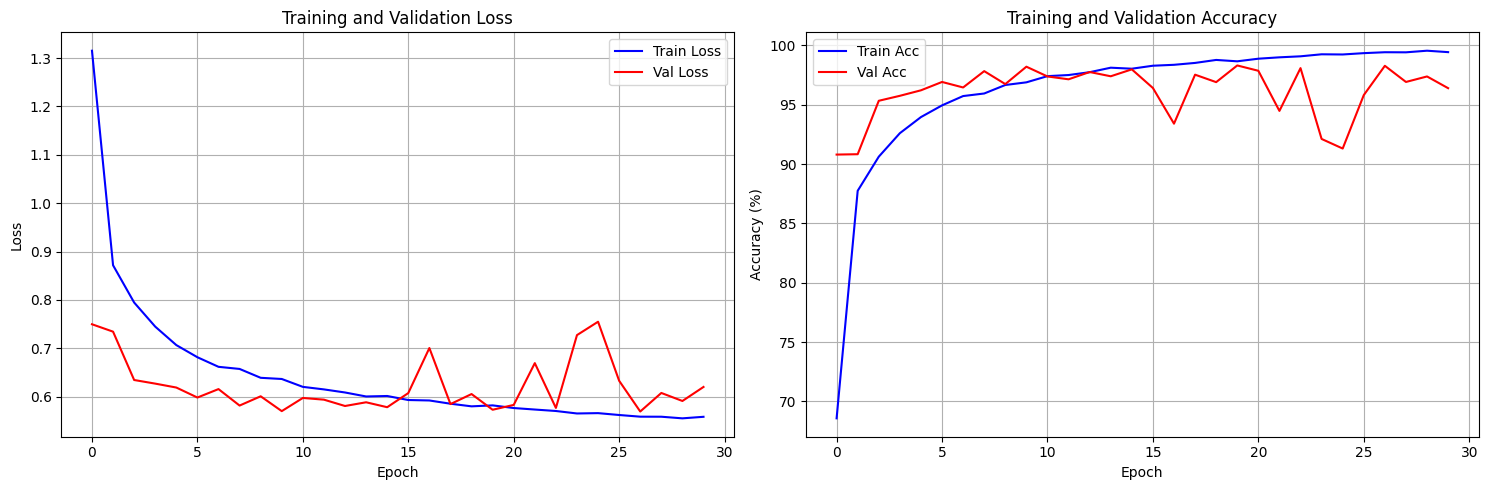

In [19]:
# Training curves - Visualize training progress over epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Create 2 subplots side by side, 15x5 inches

# Plot 1: Loss curves
ax1.plot(train_losses, label='Train Loss', color='blue')  # Plot training loss in blue
ax1.plot(val_losses, label='Val Loss', color='red')  # Plot validation loss in red
ax1.set_xlabel('Epoch')  # X-axis label
ax1.set_ylabel('Loss')  # Y-axis label
ax1.set_title('Training and Validation Loss')  # Plot title
ax1.legend()  # Show legend (Train Loss, Val Loss)
ax1.grid(True)  # Add grid for easier reading

# Plot 2: Accuracy curves
ax2.plot(train_accs, label='Train Acc', color='blue')  # Plot training accuracy in blue
ax2.plot(val_accs, label='Val Acc', color='red')  # Plot validation accuracy in red
ax2.set_xlabel('Epoch')  # X-axis label
ax2.set_ylabel('Accuracy (%)')  # Y-axis label
ax2.set_title('Training and Validation Accuracy')  # Plot title
ax2.legend()  # Show legend (Train Acc, Val Acc)
ax2.grid(True)  # Add grid for easier reading

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG (300 DPI)
plt.show()  # Display the plots


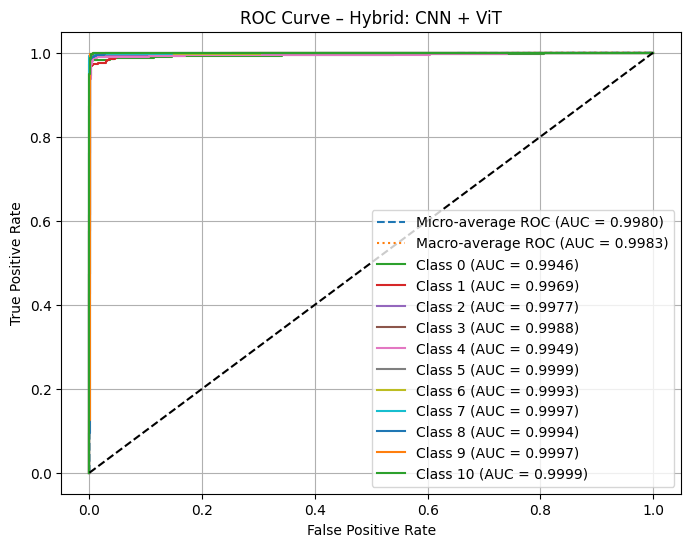

AUC Scores:
Class 0 AUC: 0.9946
Class 1 AUC: 0.9969
Class 2 AUC: 0.9977
Class 3 AUC: 0.9988
Class 4 AUC: 0.9949
Class 5 AUC: 0.9999
Class 6 AUC: 0.9993
Class 7 AUC: 0.9997
Class 8 AUC: 0.9994
Class 9 AUC: 0.9997
Class 10 AUC: 0.9999
Micro-average AUC: 0.9980
Macro-average AUC: 0.9983


In [22]:
# ===================== ROC & AUC CURVES (MULTI-CLASS) =====================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.eval()

all_probs = []
all_labels = []

# -------- Collect predictions --------
with torch.no_grad():
    for images, labels in valid_loader:   # or test_loader
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.hstack(all_labels)

# -------- Number of classes --------
num_classes = all_probs.shape[1]

# -------- Binarize labels --------
binary_labels = label_binarize(all_labels, classes=np.arange(num_classes))

# -------- ROC & AUC per class --------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -------- Micro-average ROC --------
fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# -------- Macro-average ROC --------
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ===================== PLOT =====================
plt.figure(figsize=(8, 6))

plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
    linestyle='--'
)

plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})',
    linestyle=':'
)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Hybrid: CNN + ViT')
plt.legend(loc='lower right')
plt.grid(True)

plt.savefig('roc_auc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# -------- Print AUC Scores --------
print("AUC Scores:")
for i in range(num_classes):
    print(f"Class {i} AUC: {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


Getting probabilities for ROC: 100%|██████████| 836/836 [00:40<00:00, 20.69it/s]


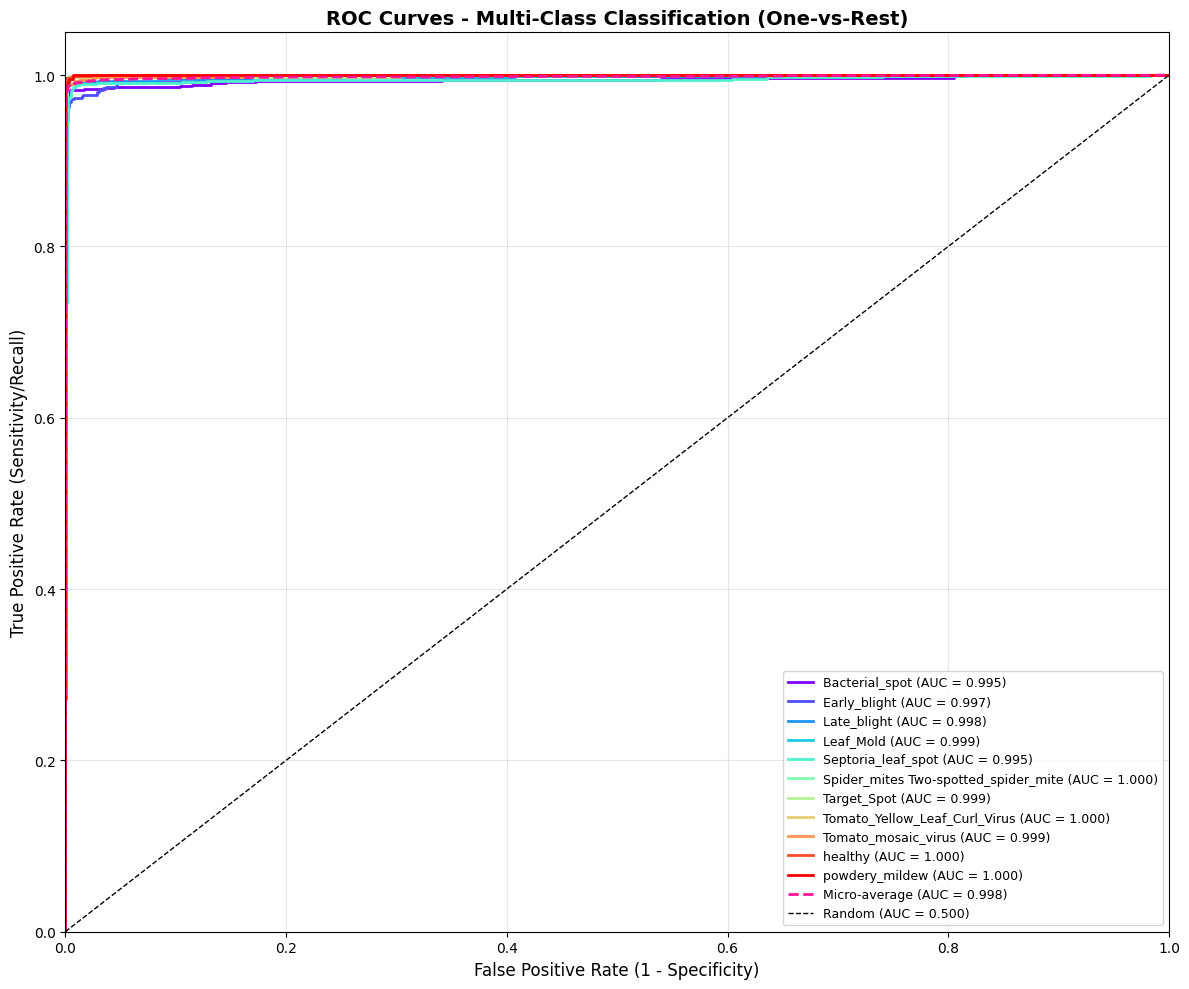


AUC (Area Under ROC Curve) Scores:
Class                     AUC Score       Interpretation
----------------------------------------------------------------------
Bacterial_spot            0.9946          Excellent
Early_blight              0.9969          Excellent
Late_blight               0.9977          Excellent
Leaf_Mold                 0.9988          Excellent
Septoria_leaf_spot        0.9949          Excellent
Spider_mites Two-spotted_spider_mite 0.9999          Excellent
Target_Spot               0.9993          Excellent
Tomato_Yellow_Leaf_Curl_Virus 0.9997          Excellent
Tomato_mosaic_virus       0.9994          Excellent
healthy                   0.9997          Excellent
powdery_mildew            0.9999          Excellent
----------------------------------------------------------------------
Macro-Average AUC         0.9983          Average of all classes
Micro-Average AUC         0.9980          Combined all classes

🎉 Excellent Model! Macro-Average AUC = 0.9983


In [21]:
# ============================================================================
# ROC CURVES and AUC SCORES - Model Performance Evaluation
# ============================================================================
# ROC (Receiver Operating Characteristic) curve shows model's ability to distinguish classes
# AUC (Area Under Curve) - Higher AUC (closer to 1.0) = Better model performance
# ============================================================================

# Import ROC and AUC functions from sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Check if predictions are available (must run Cell 14 first!)
if 'all_preds' not in globals() or 'all_labels' not in globals():
    print("="*70)
    print("⚠️  ERROR: Predictions not found!")
    print("="*70)
    print("Please run Cell 14 first to get all_preds and all_labels")
    print("="*70)
    raise NameError("all_preds and all_labels must be created first. Run Cell 14!")

# Get prediction probabilities (not just class predictions) for ROC curves
# Set model to evaluation mode
model.eval()  # Disable dropout, fix batch norm

# Lists to store probabilities and true labels
all_probs = []  # Store prediction probabilities for each class
all_labels_probs = []  # Store true labels

# Disable gradient computation (faster inference)
with torch.no_grad():
    # Create progress bar
    pbar = tqdm(valid_loader, desc='Getting probabilities for ROC')
    # Iterate through validation batches
    for images, labels in pbar:
        # Move images to device
        images = images.to(device, non_blocking=True)
        
        # Get model predictions (logits)
        outputs = model(images)  # Forward pass
        
        # Convert logits to probabilities using softmax
        probs = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities (sums to 1)
        
        # Move probabilities to CPU and convert to numpy
        all_probs.extend(probs.cpu().numpy())  # Store probabilities
        all_labels_probs.extend(labels.numpy())  # Store true labels

# Convert to numpy arrays
all_probs = np.array(all_probs)  # Shape: (num_samples, num_classes)
all_labels_probs = np.array(all_labels_probs)  # Shape: (num_samples,)

# Binarize labels for multi-class ROC (one-vs-rest approach)
# Convert labels to binary format: each class becomes a binary problem
y_true_binary = label_binarize(all_labels_probs, classes=range(num_classes))  # Shape: (num_samples, num_classes)

# Calculate ROC curve and AUC for each class
fpr = dict()  # False Positive Rate for each class
tpr = dict()  # True Positive Rate for each class
roc_auc = dict()  # AUC score for each class

# Calculate ROC for each class (one-vs-rest)
for i in range(num_classes):
    # Calculate ROC curve for class i vs all other classes
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], all_probs[:, i])
    # Calculate AUC (Area Under Curve) for class i
    roc_auc[i] = auc(fpr[i], tpr[i])  # Higher AUC = better discrimination

# Calculate micro-averaged ROC (combines all classes)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-averaged AUC (average of all class AUCs)
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(num_classes)])

# ============================================================================
# PLOT ROC CURVES
# ============================================================================
plt.figure(figsize=(12, 10))  # Create large figure for better visibility

# Plot ROC curve for each class
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))  # Different color for each class
for i, color in zip(range(num_classes), colors):
    # Plot ROC curve for class i
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')  # Label with class name and AUC

# Plot micro-averaged ROC curve (dashed line)
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')

# Plot diagonal line (random classifier baseline - AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')  # Black dashed line

# Formatting
plt.xlim([0.0, 1.0])  # X-axis: False Positive Rate (0 to 1)
plt.ylim([0.0, 1.05])  # Y-axis: True Positive Rate (0 to 1.05)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)  # X-axis label
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)  # Y-axis label
plt.title('ROC Curves - Multi-Class Classification (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)  # Legend in bottom right
plt.grid(True, alpha=0.3)  # Add grid for easier reading
plt.tight_layout()  # Adjust layout

# Save ROC curve plot
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
plt.show()  # Display the plot

# ============================================================================
# PRINT AUC SCORES
# ============================================================================
print('\n' + '='*70)
print('AUC (Area Under ROC Curve) Scores:')
print('='*70)
print(f'{"Class":<25} {"AUC Score":<15} {"Interpretation"}')
print('-'*70)

# Print AUC for each class
for i in range(num_classes):
    auc_score = roc_auc[i]
    # Interpret AUC score
    if auc_score >= 0.9:
        interpretation = "Excellent"
    elif auc_score >= 0.8:
        interpretation = "Good"
    elif auc_score >= 0.7:
        interpretation = "Fair"
    else:
        interpretation = "Poor"
    
    print(f'{class_names[i]:<25} {auc_score:<15.4f} {interpretation}')

# Print average AUC scores
print('-'*70)
print(f'{"Macro-Average AUC":<25} {roc_auc["macro"]:<15.4f} {"Average of all classes"}')
print(f'{"Micro-Average AUC":<25} {roc_auc["micro"]:<15.4f} {"Combined all classes"}')
print('='*70)

# Overall model performance assessment
if roc_auc["macro"] >= 0.95:
    print(f'\n🎉 Excellent Model! Macro-Average AUC = {roc_auc["macro"]:.4f}')
elif roc_auc["macro"] >= 0.90:
    print(f'\n✅ Very Good Model! Macro-Average AUC = {roc_auc["macro"]:.4f}')
elif roc_auc["macro"] >= 0.85:
    print(f'\n👍 Good Model! Macro-Average AUC = {roc_auc["macro"]:.4f}')
else:
    print(f'\n⚠️  Model needs improvement. Macro-Average AUC = {roc_auc["macro"]:.4f}')
print('='*70)
